## Loading necessary libraries and loading dataset

In [1]:
import os
import pandas as pd
from urllib.request import urlretrieve

def load_demand_dataset():
    # URL for the UCI dataset
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
    local_filename = "Daily_Demand_Forecasting_Orders.csv"

    # Download the file if it doesn't exist
    if not os.path.exists(local_filename):
        print("Downloading dataset...")
        urlretrieve(dataset_url, local_filename)

    # Load the dataset
    df = pd.read_csv(local_filename, delimiter=';', decimal=',')
    print(f"Dataset loaded with shape: {df.shape}")
    return df


In [2]:
df = load_demand_dataset()
df.head(5)

Dataset loaded with shape: (60, 13)


,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


## Creating Sequences

In [3]:
import numpy as np

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7

In [4]:
target_column = 'Target (Total orders)'

x = df.drop(target_column, axis=1)
y = df[target_column]

## Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler(feature_range=(0,1))
X_scaled = mn.fit_transform(x)
y_scaled = mn.fit_transform(df[[target_column]])

In [6]:
train_size = int(len(X_scaled)*0.8)

## Train - Test - Split

In [7]:
# Splitting data
X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]

# Creating a sequences
X_train, y_train = create_sequences(X_train_data, y_train_data, sequence_length)
X_test, y_test = create_sequences(X_test_data, y_test_data, sequence_length)

## Importing necessary libraries

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

## Building LSTM model

In [9]:
def build_model(seq,n_features):
  model = Sequential([
      LSTM(64,return_sequences=True,input_shape=(seq,n_features)),
      LSTM(64,return_sequences=True,recurrent_dropout=0.1),
      LSTM(64,recurrent_dropout=0.1),
      Dropout(0.2),
      Dense(1)
  ])
  model.compile(optimizer='adam',loss='mean_squared_error')
  return model

In [10]:
model = build_model(sequence_length,x.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,825 (335.25 KB)

 Trainable params: 85,825 (335.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf

## Early Stopping

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(
 monitor='val_loss',
 patience=15,
 restore_best_weights=True
)

## Learning rate scheduler

In [14]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
 monitor='val_loss',
 factor=0.5,
 patience=5,
 min_lr=0.0001
)

## Training the model

In [15]:
hist = model.fit(
    X_train,y_train,
    epochs = 100,
    batch_size = 16,
    validation_split=0.2,
    callbacks=[early_stop,lr_scheduler],
    verbose=1
)
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.1433 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0960 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0320 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0438 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0582 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0418 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0314 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0357 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0440 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━

## Visualization

In [16]:
import tensorflow.keras.utils

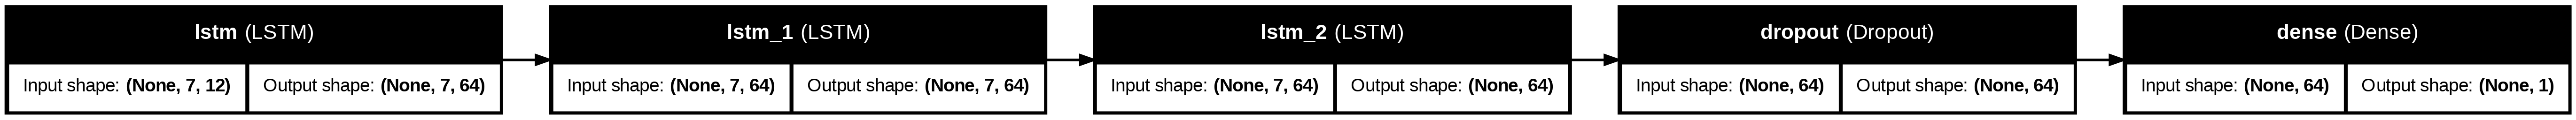

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True,
show_layer_names=True, rankdir='LR')

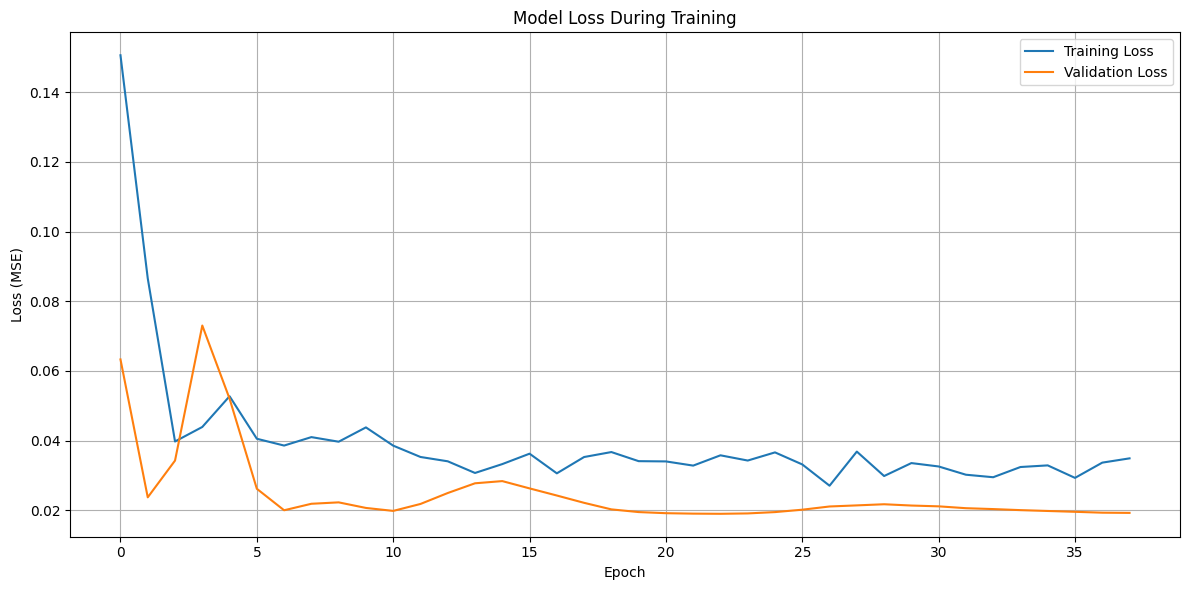

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()
